# Lab 09-4 Batch Normalization
- Gradient Vanishing / Exploding
- Internal Covariate Shift
- Batch Normalization
- Code: mnist_batchnorm

- Gradient Vanishing : 시그모이드를 사용할 때의 문제점
- Gradient Exploding : 그래디언트 너무 크게 계산되어서 발생하는 문제
- Solution :
    - Change activation function
    - Careful initialization
    - Small learning rate
- 이런 간접적인 솔루션 말고 직접적으로 해결할 수 있는 **Batch Normalization**이 있다.
    - gradient vanishing/exploding 뿐만 아니라, 전체적으로 학습 과정이 굉장히 stable되고, 추가적으로 dropout 같은 regularization 효과. 속도의 가속 등의 효과가 있음.

## Internal Covariate Shift


Train/Test set의 분포가 실제로는 차이가 있다.
dist의 차이가 어떤 문제점을 발생시킨다.

covariate shift : 어떤 차이의 개념

레이어들끼리 covariate shift가 발생한다. 레이어 많을수록 더 심해짐


**Input:** Values of x over a mini-batch: $B = \{x_{1...m}\}$

Parameters to be learned: $\gamma$, $\beta$

**Output:** $\{y_i = BN_{\gamma, \beta}(x_i)\}$

$\mu_B \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i $      // mini-batch mean

$\sigma^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2$     // mini-batch variance

$\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$   // normalize

$y_i \leftarrow \gamma \hat{x_i} + \beta \equiv BN_{\gamma, \beta}(x_i)$  // scale and shift

**Algorithm 1:** Batch Normalizing Transform, applied to activation $x$ over a mini-batch.


scale/shift 하는 것은 데이터를 계속 정규화하게 되면 활성화 함수의 비선형 같은 성질을 잃게 되는데 이러한 문제를 완화하기 위함. (입력 값이 N(0, 1)이므로 95퍼센트의 입력 값은 sigmoid 함수 그래프의 중간(x = (-1.96, 1.96))에 속하고 이 부분이 선형이기 때문.)

In [ ]:
model.train()  # dropout=True
model.eval()   # dropout=False

문제점 : x가 달라지면 mu, variance가 다른 값을 갖게 됨.

8개 배치 있다 할 때 mu, var 구하고 이후에 마지막 2개 배치 바꿔서 mu, var 구한다 치면 처음과 이후의 mu, var가 서로 다름.

그래서 batch norm.에서는 train 모드와 evaluation 모드 따로 둠.

학습 당시 구한 mean, var를 sample mean/var라 하는데, 이런 sample mean/var들을 따로 저장해두고, 평균 계산해서(learning mean/var?) 입력 데이터 상관없이 고정된 값으로 이 값들 이용해서 inference에서 normalize에 쓴다.

-> 이렇게 문제점을 해결할 수 있다.

## Code: mnist_batchnorm

In [9]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [11]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [12]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [13]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [15]:
## nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                              linear2, bn2, relu,
                              linear3)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                              nn_linear2, relu,
                              nn_linear3)

In [16]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [17]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.12169(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18437(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.13124(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20023(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10419(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16524(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12713(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19851(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.08848(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.15103(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.10775(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.18845(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07067(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.13872(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09809(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.18037(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [18]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

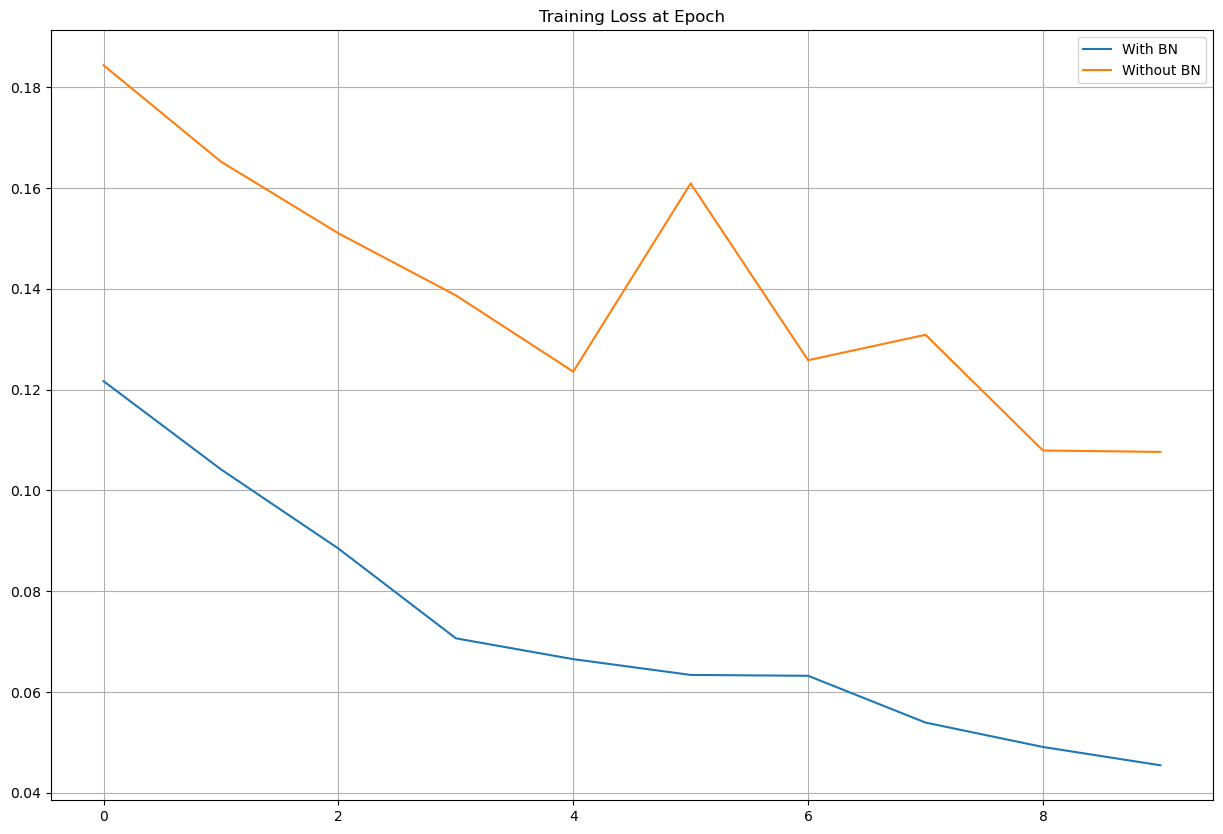

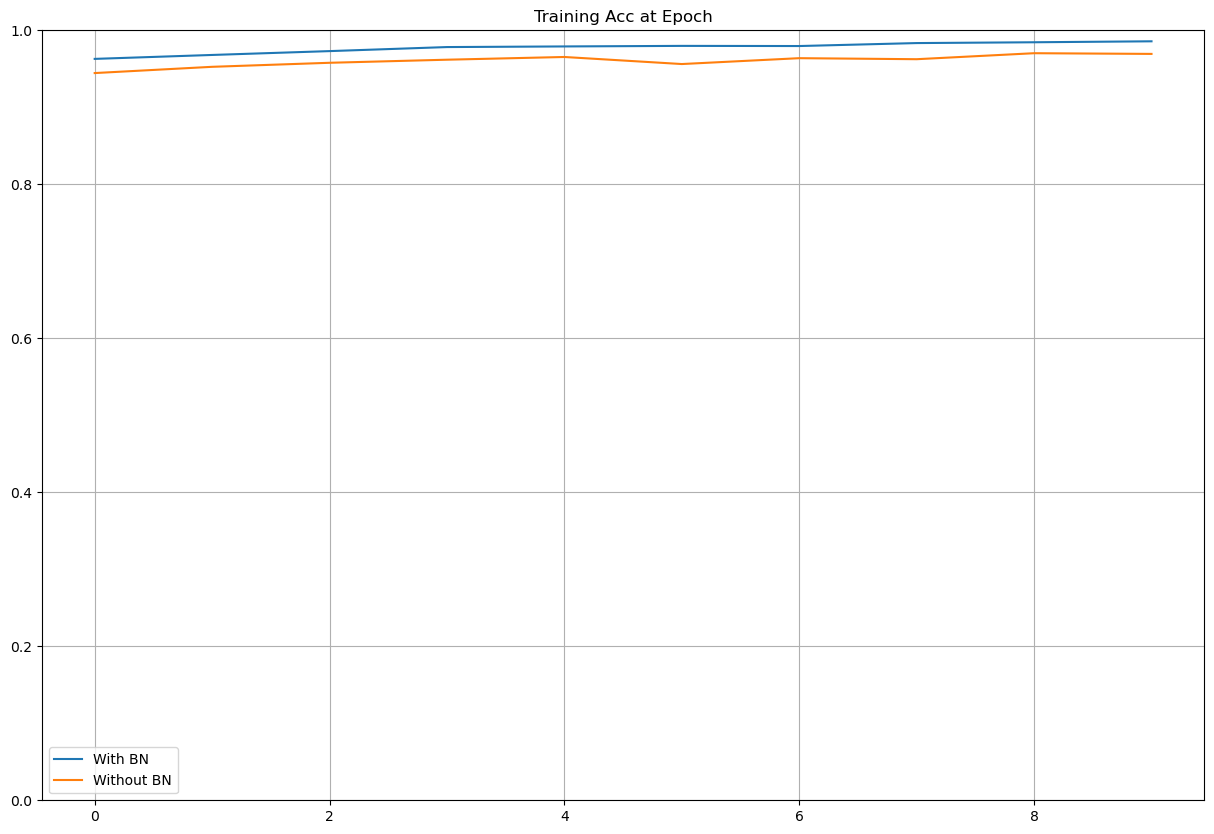

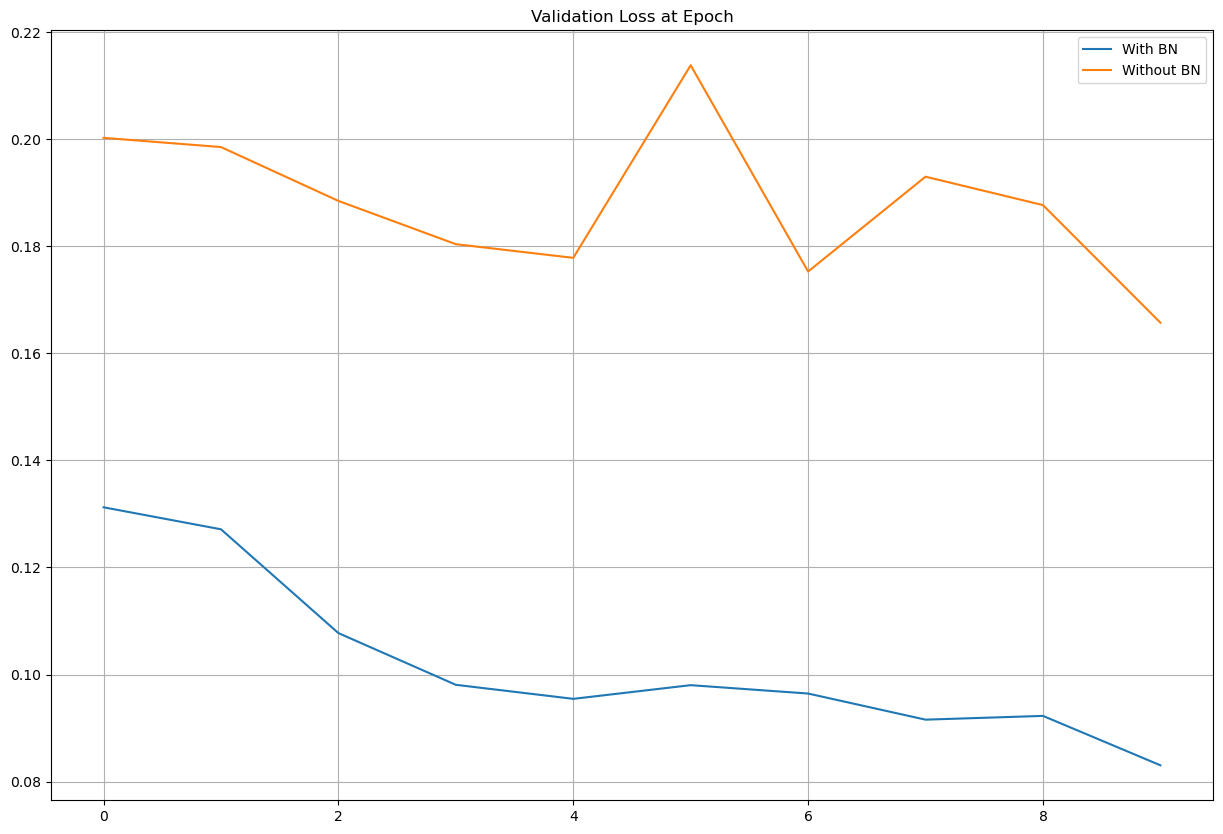

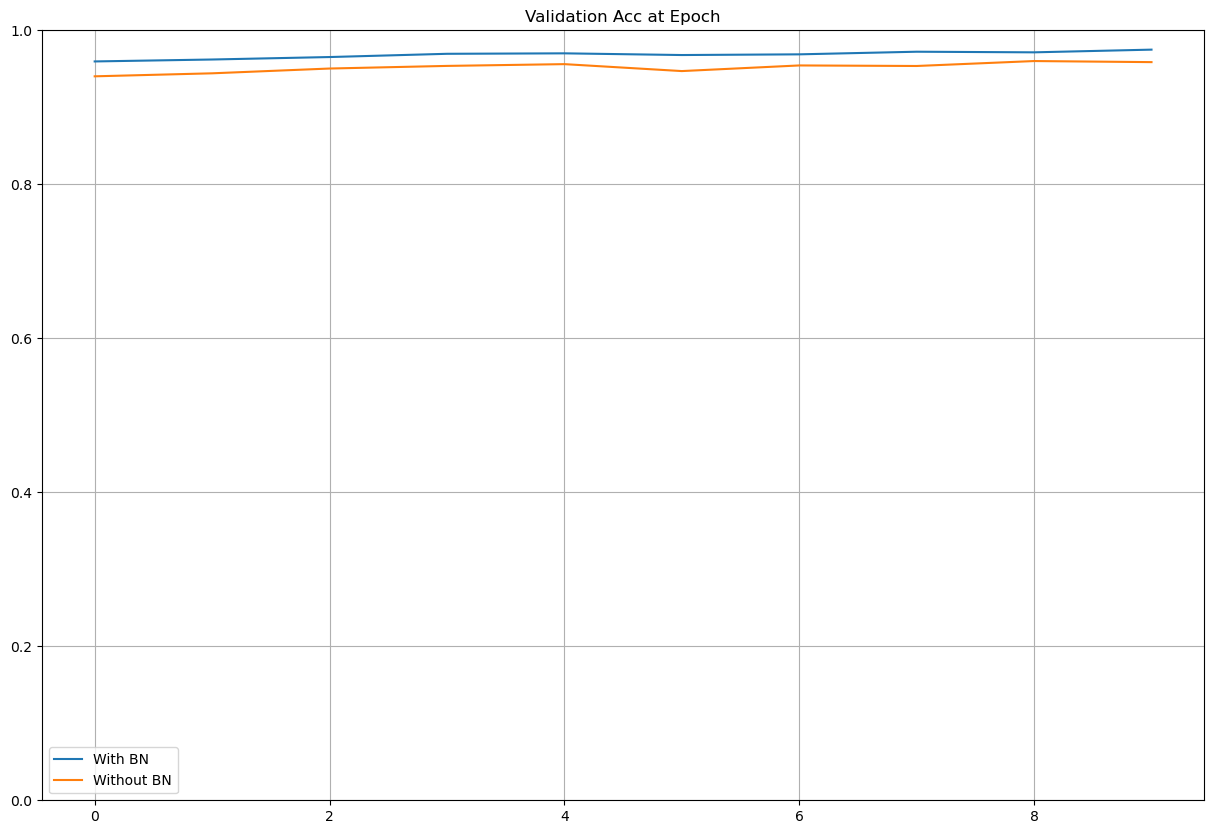

In [19]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')

더 정확도가 높음.

이것밖에 안 되나라고 생각할 수도 있겠지만, batch norm.의 성능은 MNIST 말고 더 많은 클래스, 더 어렵고 훨씬 많은 데이터들 ImageNet 같은거 하면 더 눈에 띄게 할 수 있다.